In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils

In [2]:
register_matplotlib_converters()

%matplotlib notebook
%matplotlib inline

# Options

In [14]:
query = """
    select
        put_call
        , description
        , bid
        , ask
        , last
        , close_price
        , total_volume
        , open_interest
        , strike
        , days_to_expiration
        , expiration_date_from_epoch::date
        , file_datetime::date
    from td.options
    where file_datetime::date = '2020-03-18' 
        and symbol = 'T'
    order by put_call, days_to_expiration, strike
    """

options = utils.query_db(query=query)

options.head(3).T

,0,1,2
put_call,CALL,CALL,CALL
description,T Mar 20 2020 17 Call,T Mar 20 2020 18 Call,T Mar 20 2020 19 Call
bid,14.3,13.3,12.35
ask,18.8,17.9,16.6
last,16.4,0,14.35
close_price,16.74,15.74,14.74
total_volume,0,0,0
open_interest,4,0,0
strike,17,18,19
days_to_expiration,2,2,2


In [202]:
_STOCK_PRICE = 32.85

_strike = np.median(options['strike'].unique())
_expiration = np.sort(options['days_to_expiration'].unique())[7]

In [203]:
_OPTION_PRICE_COL = 'ask'
_options = options.loc[
    (options['open_interest']>0) 
    & (options['put_call']=='CALL')
    & (options['days_to_expiration']==_expiration) 
#     & (options['strike']==_strike)
].copy()

_options['break_even'] = _options['strike'] + _options[_OPTION_PRICE_COL]
_options['distance'] = _options['break_even'] - _STOCK_PRICE

In [204]:
_options.head()

,put_call,description,bid,ask,last,close_price,total_volume,open_interest,strike,days_to_expiration,expiration_date_from_epoch,file_datetime,break_even,distance
267,CALL,T Jun 19 2020 20 Call,11.50,15.80,18.39,14.74,0.0,1.0,20.0,93.0,2020-06-19,2020-03-18,35.80,2.95
270,CALL,T Jun 19 2020 23 Call,10.65,11.45,9.75,11.94,0.0,55.0,23.0,93.0,2020-06-19,2020-03-18,34.45,1.60
272,CALL,T Jun 19 2020 25 Call,9.15,10.60,8.45,10.24,0.0,49.0,25.0,93.0,2020-06-19,2020-03-18,35.60,2.75
273,CALL,T Jun 19 2020 26 Call,8.15,10.95,8.40,9.39,0.0,67.0,26.0,93.0,2020-06-19,2020-03-18,36.95,4.10
274,CALL,T Jun 19 2020 27 Call,7.35,8.95,7.68,8.54,0.0,162.0,27.0,93.0,2020-06-19,2020-03-18,35.95,3.10


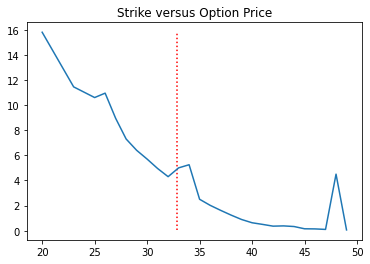

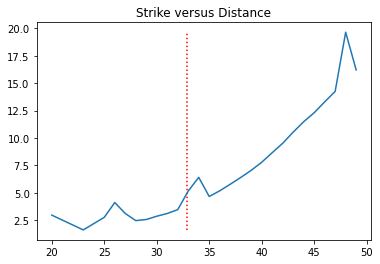

In [205]:
plt.title('Strike versus Option Price')
plt.plot(_options['strike'], _options[_OPTION_PRICE_COL])
plt.vlines(
    _STOCK_PRICE,
    ymin=_options[_OPTION_PRICE_COL].min(),
    ymax=_options[_OPTION_PRICE_COL].max(),
    colors='r',
    linestyles='dotted'
)
plt.show()

plt.title('Strike versus Distance')
plt.plot(_options['strike'], _options['distance'])
plt.vlines(
    _STOCK_PRICE,
    ymin=_options['distance'].min(),
    ymax=_options['distance'].max(),
    colors='r',
    linestyles='dotted'
)
plt.show()

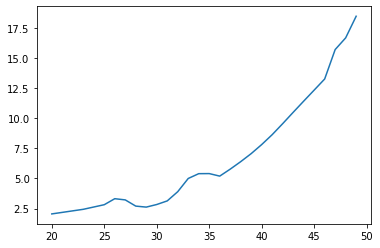

In [206]:
plt.plot(
    _options['strike'], 
    (
        (
            _options['distance']
            + _options['distance'].shift(1, fill_value=_options['distance'].min())
            + _options['distance'].shift(-1, fill_value=_options['distance'].max())
        )/3
    )
)
plt.show()